<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Prediction_next_month_transactions_with_linear_regression_CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [175]:
from google.colab import files
uploaded = files.upload()

Saving Online_Retail_Dataset.xlsx to Online_Retail_Dataset (2).xlsx


In [176]:
# Dataset is now stored in a Pandas Dataframe
import io
df = pd.read_excel(io.BytesIO(uploaded.get('Online_Retail_Dataset.xlsx')))

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [178]:
df.shape

(541909, 8)

Exploratory Data Analysis

Null Values

In [179]:
print('Number of missing values in the dataset:', df.isnull().sum().sum())
print('Percentage of missing values in the dataset:', df.isnull().sum().sum()*100/(df.shape[0]*df.shape[1]))

Number of missing values in the dataset: 136534
Percentage of missing values in the dataset: 3.149375633178264


In [180]:
print("Number of missing values in 'Description' column:", df['Description'].isnull().sum())
print("Percentage of missing values in 'Description' column:", df['Description'].isnull().sum()*100/df.shape[0])

Number of missing values in 'Description' column: 1454
Percentage of missing values in 'Description' column: 0.2683107311375157


In [181]:
print("Number of missing values in 'CustomerID' column:", df['CustomerID'].isnull().sum())
print("Percentage of missing values in 'CustomerID' column:", df['CustomerID'].isnull().sum()*100/df.shape[0])

Number of missing values in 'CustomerID' column: 135080
Percentage of missing values in 'CustomerID' column: 24.926694334288598


About 25% of CustomerIDs is missing

Duplicates

In [182]:
# Check the number of duplicated values
df.duplicated().sum().sum()

5268

In [183]:
# Let's get the duplicated rows
duplicates = df[df.duplicated()]

In [184]:
duplicates[:20]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
587,536412,22273,FELTCRAFT DOLL MOLLY,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
589,536412,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,1,2010-12-01 11:49:00,3.75,17920.0,United Kingdom
594,536412,22141,CHRISTMAS CRAFT TREE TOP ANGEL,1,2010-12-01 11:49:00,2.10,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
600,536412,22569,FELTCRAFT CUSHION BUTTERFLY,2,2010-12-01 11:49:00,3.75,17920.0,United Kingdom


It seems that products, which were bought together in one invoice, were considered as duplicates. However, there are no duplicates, if we look at the Description column

Number of Unique Customers

In [185]:
df['CustomerID'].nunique()

4372

Number of Purchases

In [186]:
df['InvoiceNo'].nunique()

25900

Period of Time

In [187]:
df['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [188]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

Country

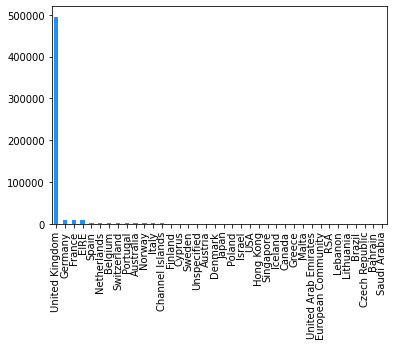

In [189]:
df['Country'].value_counts().plot.bar(color='dodgerblue');

In [190]:
df['Country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

As you can see, the majority of purchases was made in the UK. Germany, France and EIRE have about 2% of purchases.

In [191]:
df['Country'].nunique()

38


So we have approximately 1 year data record of 25,900 purchases for 4,372 unique users made in 38 countries (mostly in the UK)

Quantity and unit price of the products

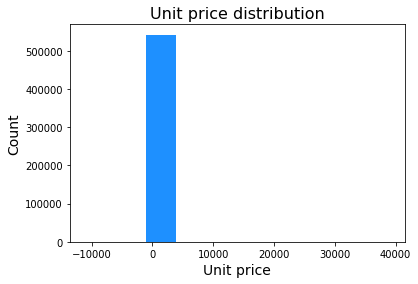

In [192]:
# Let's look at the price distribution of the products

plt.hist(data=df, x='UnitPrice', color='dodgerblue')
plt.xlabel('Unit price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Unit price distribution", fontsize=16);

It seems that we have negative values and some outliers representing very expensive products. The negative values may be associated with cancelled or refunded orders. Let's remove negative records and outliers and look at the price distribution.

In [193]:
df['UnitPrice'].describe(percentiles=[.99])

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
50%           2.080000
99%          18.000000
max       38970.000000
Name: UnitPrice, dtype: float64

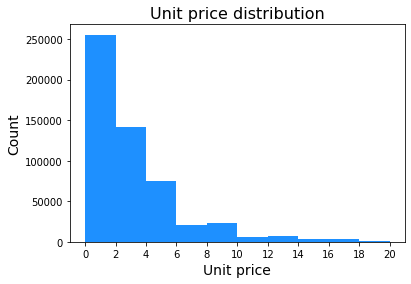

In [194]:
bins = np.arange(0, 21, 2)
ticks = np.arange(0, 21, 2)
plt.hist(data=df, x='UnitPrice', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('Unit price', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Unit price distribution', fontsize=16);


The price for most of the products is equal or less than 10£

Let's look at the negative values in UnitPrice

In [195]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


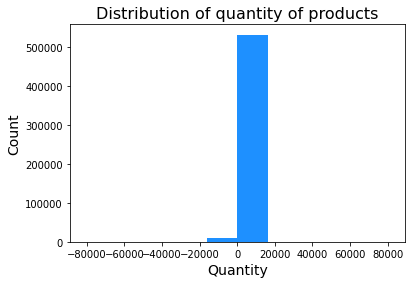

In [196]:
# Let's look at the quantity of the products

plt.hist(data=df, x='Quantity', color='dodgerblue')
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Distribution of quantity of products", fontsize=16);

In [197]:
df['Quantity'].describe(percentiles=[.99])

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
50%           3.000000
99%         100.000000
max       80995.000000
Name: Quantity, dtype: float64

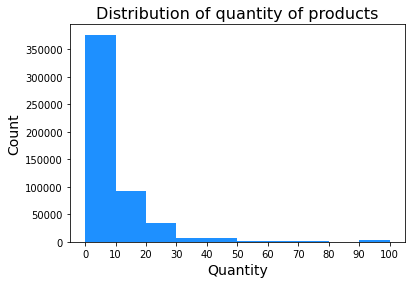

In [198]:
bins = np.arange(0, 110, 10)
ticks = np.arange(0, 110, 10)
plt.hist(data=df, x='Quantity', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('Quantity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of quantity of products', fontsize=16);


In most cases customers buy less than 50 items per order.

Let's look at the negative values in Quantity

In [199]:
neg_quantity = df[df['Quantity']<0]

In [200]:
neg_quantity.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


In [201]:
neg_quantity.shape

(10624, 8)

In [202]:
print("The percentage of records with negative Quantity:", neg_quantity.shape[0]*100/df.shape[0])

The percentage of records with negative Quantity: 1.9604767590130445


There are 10,624 raws with negative Quantity values, which is about 2% out of the total number of records in the dataframe.

Data Cleaning and Transformation

Dropping Null Values

We have NULL records in columns CustomerId and Description. Let's drop rows containing NULL values.

In [203]:
df.dropna(subset=['CustomerID'], inplace=True)

In [204]:
df.shape

(406829, 8)

In [205]:
# Let's check NULL records in the CustomerId column
df['CustomerID'].isnull().sum()

0

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


Handle Negative Quantity

In [207]:
df = df.loc[df['Quantity'] > 0]

In [208]:
# Let's check negative records
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Remove rows with negative price

In [209]:
df = df.loc[df['UnitPrice'] > 0]

In [210]:
# Let's check negative records
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Handle Incomplete Data

Period of time for the purchase records is from December 1, 2010 to December 9, 2011. The data for the last month is incomplete. Because we are planning to predict transactions for the next month, let us ignore the records for the incomplete month.

In [211]:
df = df.loc[df['InvoiceDate'] < '2011-12-01']

In [212]:
# Let's check the time period
df['InvoiceDate'].min(), df['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-11-30 17:37:00'))

Calculate Total Sales


Let us create a column for the total sales value for each transaction

In [213]:
df['TotalSum'] = df['Quantity'] * df['UnitPrice']

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380580 entries, 0 to 516368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    380580 non-null  object        
 1   StockCode    380580 non-null  object        
 2   Description  380580 non-null  object        
 3   Quantity     380580 non-null  int64         
 4   InvoiceDate  380580 non-null  datetime64[ns]
 5   UnitPrice    380580 non-null  float64       
 6   CustomerID   380580 non-null  float64       
 7   Country      380580 non-null  object        
 8   TotalSum     380580 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 29.0+ MB


Define Invoice Month

In [215]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

In [216]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [217]:
df['InvoiceMonth'] = df['InvoiceMonth'].astype(str)

Remove customer ids, which have only records for the last month

Because we are planning to predict next month transactions. Therefore, it's important to keep customers, who have records for more than one month. Let us drop cusomer ids, which appered from the last month in the dataframe.

In [218]:
max(df['InvoiceDate']), min(df['InvoiceDate'])

(Timestamp('2011-11-30 17:37:00'), Timestamp('2010-12-01 08:26:00'))

In [219]:
# Split into 2 dataframes to check customer ids
df_nov = df[df['InvoiceMonth'] == '2011-11']
df_other_months = df[df['InvoiceMonth'] != '2011-11']

In [220]:
df_nov.shape

(64531, 10)

In [221]:
df_other_months.shape

(316049, 10)

In [222]:
df_nov['CustomerID'].nunique()

1664

In [223]:
df_other_months['CustomerID'].nunique()

3974

In [224]:
cust_ids_nov = df_nov['CustomerID'].unique().tolist()
cust_ids_others = df_other_months['CustomerID'].unique().tolist()


Basically, we have to exclude customer ids, which appeared for the first time in November 2011.

In [225]:
new_cust_ids = list(set(cust_ids_nov) - set(cust_ids_others))

In [226]:
len(new_cust_ids)

323

We have 323 new customers or customers with only with purchasing activity for the last month in the dataset. Let us drop the customer ids from the dataset.

In [227]:
# Dataframe before removing the cusomer ids
df.shape

(380580, 10)

In [228]:
df = df[~df['CustomerID'].isin(new_cust_ids)]

In [229]:
# Dataframe after removal the customer ids
df.shape

(369381, 10)

Create a column to mark purchases from the UK, Germany, France and EIRE

In [230]:
df['IsUnitedKingdom'] = df['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
df['IsGermany'] = df['Country'].apply(lambda x: 1 if x == 'Germany' else 0)
df['IsFrance'] = df['Country'].apply(lambda x: 1 if x == 'France' else 0)
df['IsEIRE'] = df['Country'].apply(lambda x: 1 if x == 'EIRE' else 0)

In [231]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceMonth,IsUnitedKingdom,IsGermany,IsFrance,IsEIRE
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,1,0,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,1,0,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,1,0,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,1,0,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,1,0,0,0


In [232]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalSum,IsUnitedKingdom,IsGermany,IsFrance,IsEIRE
count,369381.000000,369381.000000,369381.000000,369381.000000,369381.000000,369381.000000,369381.000000,369381.000000
mean,12.978361,3.149688,15281.882836,22.352593,0.888397,0.023326,0.021241,0.018726
std,129.619821,22.753514,1709.863872,160.511495,0.314878,0.150935,0.144187,0.135556
min,1.000000,0.001000,12346.000000,0.001000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.250000,13956.000000,4.950000,1.000000,0.000000,0.000000,0.000000
50%,6.000000,1.950000,15149.000000,12.480000,1.000000,0.000000,0.000000,0.000000
75%,12.000000,3.750000,16775.000000,19.800000,1.000000,0.000000,0.000000,0.000000
max,74215.000000,8142.750000,18287.000000,77183.600000,1.000000,1.000000,1.000000,1.000000


**Feature Engineering**


Let us create RFM features to predict customer transactions for the next month. First, let us choose only records for previous months, which we will be using for predicting transactions for the next month.

In [233]:
df_X = df[df['InvoiceMonth'] != '2011-11']

In [234]:
max(df_X['InvoiceMonth'])

'2011-10'

In [235]:
now = dt.datetime(2011, 11, 1)

In [236]:
df_features = df_X.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days,
                                              'InvoiceNo': pd.Series.nunique,
                                              'TotalSum': np.sum,
                                              'Quantity': ['mean', 'sum'],
                                              'IsUnitedKingdom': np.mean,
                                              'IsGermany': np.mean,
                                              'IsFrance': np.mean,
                                              'IsEIRE': np.mean}).reset_index()

In [237]:
df_features.columns = ['CustomerID', 'Recency', 'Frequency', 
                       'Monetary', 'QuantityAvg', 'QuantityTotal',
                       'IsUK', 'IsGermany', 'IsFrance', 'IsEIRE']

In [238]:
df_features.head()

,CustomerID,Recency,Frequency,Monetary,QuantityAvg,QuantityTotal,IsUK,IsGermany,IsFrance,IsEIRE
0,12346.0,286,1,77183.60,74215.000000,74215,1,0,0,0
1,12347.0,0,6,4085.18,13.251462,2266,0,0,0,0
2,12348.0,36,4,1797.24,75.516129,2341,0,0,0,0
3,12350.0,271,1,334.40,11.588235,197,0,0,0,0
4,12352.0,33,7,2194.31,5.842857,409,0,0,0,0


In [239]:
df_features.shape

(3974, 10)

In [240]:
# Get monthly transactiins for customers
cust_month_trans = pd.pivot_table(data=df,
                                  index=['CustomerID'],
                                  values='InvoiceNo',
                                  columns=['InvoiceMonth'],
                                  aggfunc=pd.Series.nunique,
                                  fill_value=0).reset_index()

In [241]:
cust_month_trans = cust_month_trans.rename_axis('index',axis=1)

In [242]:
cust_month_trans.head()

index,CustomerID,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
0,12346.0,0,1,0,0,0,0,0,0,0,0,0,0
1,12347.0,1,1,0,0,1,0,1,0,1,0,1,0
2,12348.0,1,1,0,0,1,0,0,0,0,1,0,0
3,12350.0,0,0,1,0,0,0,0,0,0,0,0,0
4,12352.0,0,0,1,4,0,0,0,0,0,2,0,1


In [243]:
cust_month_trans.shape

(3974, 13)

In [244]:
customer_id = ['CustomerID']
target = ['2011-11']

In [245]:
y = cust_month_trans[target]

In [246]:
y.head()

index,2011-11
0,0
1,0
2,0
3,0
4,1


In [247]:
cols = [col for col in df_features.columns if col not in customer_id]

In [248]:
X = df_features[cols]

In [249]:
X.head()

,Recency,Frequency,Monetary,QuantityAvg,QuantityTotal,IsUK,IsGermany,IsFrance,IsEIRE
0,286,1,77183.60,74215.000000,74215,1,0,0,0
1,0,6,4085.18,13.251462,2266,0,0,0,0
2,36,4,1797.24,75.516129,2341,0,0,0,0
3,271,1,334.40,11.588235,197,0,0,0,0
4,33,7,2194.31,5.842857,409,0,0,0,0


Linear Regression

In [250]:
from sklearn.model_selection import train_test_split

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [252]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2980, 9) (2980, 1) (994, 9) (994, 1)


In [253]:
from sklearn.linear_model import LinearRegression

In [254]:
linreg = LinearRegression()

In [255]:
model = linreg.fit(X_train, y_train)

In [256]:
train_pred_y = model.predict(X_train)

In [257]:
test_pred_y = model.predict(X_test)

In [258]:
model.coef_

array([[ 1.38235892e-05,  1.62737522e-01, -6.74327850e-06,
         2.65846234e-06,  1.04616400e-06, -7.97447952e-03,
         1.22491166e-01,  7.58714804e-02,  2.00303374e+00]])

In [260]:
model.intercept_

array([-0.03079184])

**Model** **Evaluation**

In [261]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [262]:
mse_train = np.sqrt(mean_squared_error(y_train, train_pred_y))

In [263]:
mae_train = mean_absolute_error(y_train, train_pred_y)

In [264]:
mse_test = np.sqrt(mean_squared_error(y_test, test_pred_y))

In [265]:
mae_test = mean_absolute_error(y_test, test_pred_y)

In [266]:
print('MSE train: {:.3f}; MSE test: {:.3f}\nMAE train: {:.3f}, MAE test: {:.3f}'.format(mse_train,
                                                                                        mse_test,
                                                                                        mae_train,
                                                                                        mae_test))

MSE train: 0.944; MSE test: 0.878
MAE train: 0.576, MAE test: 0.577


In [267]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [268]:
y_train = np.array(y_train)

In [269]:
ols_reg = sm.OLS(y_train, X_train)

In [270]:
ols_reg = ols_reg.fit()

In [271]:
print(ols_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.649
Model:                            OLS   Adj. R-squared (uncentered):              0.648
Method:                 Least Squares   F-statistic:                              609.8
Date:                Sun, 24 Oct 2021   Prob (F-statistic):                        0.00
Time:                        16:56:23   Log-Likelihood:                         -4057.5
No. Observations:                2980   AIC:                                      8133.
Df Residuals:                    2971   BIC:                                      8187.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

If we decide our statistical significance at 95%, features with p values with less than or equal to 5% are considered as statistically significant. Looking at p values, we can say that Frequency and IsEIRE features are statistically significant to predict the number of transactions for the next month.


Summary
We predicted next month transactions based on engineered RFM features using linear regression
Looking at p values, we can say that Frequency and IsEIRE features are statistically significant to predict the number of transactions for the next month
R-squared = 0.649, which means that the model explains about 64.9% of the variation, which is good. However, we could create other features and fit other models to improve the metric.